# Introduction

Sao Paulo is the largest city in Brazil presenting a city population of about 12.25 million and almost 22 million in its metropolitan region (2019). It is the capital of the Southeastern state of São Paulo, and  one of the richest cities in the southern hemisphere. Historically attractive to immigrants as well as (somewhat later) Brazilians from other states, it's one of the most diverse cities in the world.

Sao Paulo is Brazil technological and economical hub. It has the largest economy by Gross Domestic Product (GDP) in Latin America and the Southern Hemisphere, representing 10.7% of all Brazilian GDP and being home to 63% of stablished multinational companies in the country.

According to the Brazilian Association of the Pet Products (Abinpet), Brazil has the second largest population of dogs, cats and domestic songbirds worldwide and is the third largest country in pet total population only. According to Euromonitor, there are about 150 million pets in the country - a larger number than Brazilian children, for example. Still according to Euromonitor, the Brazilian market for pet products is the fourth largest in the world in terms of sales volume and presented a 10.8% Compound Annual Growth Rate (CAGR) between 2014 and 2019. The evolution of this market in the country was mainly driven by the increase in the pet population. In the next five years, this growth rate is expected to reach a 16.6% CAGR.

The number of pet stores (or pet shops) in Sao Paulo city almost doubled between 2006 and 2016 reaching 3072 stores. According to Instituto Pet Brasil this business generates R$ 23 billion (USD 4 billion) each year including veterinary products, pet food and accessories and services.

Considering this growing market in Sao Paulo, what should a business person take into account before making the decision to open a pet store? What is the best location in Sao Paulo and why?

# Business Problem

The goal is to find a proper location to open a pet store by clustering the districts of Sao Paulo. I will explore, segment and cluster districts in Sao Paulo and find main features related to the business. In this report I will find the pet stores based on the total number of stores and their ratings. By clustering data using Foursquare API, I can provide information about the best location to open a pet store in the city.

1. What is / are the best location(s) for pet store in Sao Paulo city?
2. In what district should the investor open a pet store to have the best chance of being successful?

# Data

I used the BeautifulSoap library for webscraping data in Wikipedia website. The code will be provided in Jupyter Notebook.
https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_S%C3%A3o_Paulo_por_popula%C3%A7%C3%A3o

Then I have to find Sao Paulo districts geographical coordinates. At first, I tried to use Google services, but it asks the user a credit card number. Then geocoder class from Geopy client worked just fine to extract latitude and longitude coordinates for each Sao Paulo district. This data is uploaded to Google Drive and a method to call it is provided in the Notebook.

For venues in each Sao Paulo district, I used Foursquare API tools. It collects venues available along with their categories, ratings and counts for likes and tips.

For data preparation, I had to check the file for any NA cell concerning latitude and longitude coordinates for the districts. There are 96 districts on the CSV dataframe, and dropped the original 'Population' column for this project.

In the next step, I used the Foursquare API tool to extract a maximum 120 venues located within a 600 meter radius based on latitude and longitude coordinates from city districts. 

Then, Foursquare API is used to collected ratings, likes and tips for Pet Stores in Sao Paulo districts. Filtered Pet Stores based on minimum ratings and plotted a bar chart for decision making.
I will select districts where I can find at least one Pet Store, along with their respective average ratings and merged these columns with geographical coordinates.

## Importing all required libraries

In [1]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#gdown library used to download data from Google Drive
!pip install gdown

!conda install -c conda-forge folium=0.5.0 --yes
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors

#for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import datasets

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



## Web scrapping data from Wikipedia

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [3]:
url_wiki = 'https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_S%C3%A3o_Paulo_por_popula%C3%A7%C3%A3o'

response = requests.get(url_wiki)

soup = BeautifulSoup(response.text, "html.parser")

table = soup.find('table', {'class':'wikitable sortable'}).tbody

In [4]:
rows = table.find_all('tr')
columns= [v.text.replace('\n', '') for v in rows[0].find_all('th')]
print(columns)

['Posição', 'Distrito', 'População 2010']


In [5]:
df=pd.DataFrame(columns=columns)
df.shape

(0, 3)

Populating the table with data

In [6]:
for i in range (1,len(rows)-1): #find skipping the first row, search in all rows minus last rows (there is a issue on wiki table with 4 columns in last rows)
    tds=rows[i].find_all('td')
    #inspect ...rowspan 2 td tags, otherwise 3 td tags
    if len(tds) == 2:
        values = [tds[0].text.replace('\n', ''), tds[1].text.replace('\n', ''), tds[2].text.replace('\n', '')]
    else:
        values=[td.text.replace('\n', '') for td in tds]
    #print(values)
    #print(np.shape(values))
    df=df.append(pd.Series(values, index=columns), ignore_index=True)
    #print(df)

In [7]:
print(df)

   Posição         Distrito População 2010
0        1           Grajaú        360.787
1        2    Jardim Ângela        295.434
2        3        Sapopemba        284.524
3        4    Capão Redondo        268.729
4        5  Jardim São Luís        267.871
..     ...              ...            ...
91      92          Jaguara         24.895
92      93               Sé         23.651
93      94             Pari         17.299
94      95      Barra Funda         14.383
95      96         Marsilac          8.258

[96 rows x 3 columns]


In [8]:
df.to_csv(r'C:\Users\Danilo\Downloads\Capstone' + 
         '\\saopaulo_districts.csv', index=False)

In [9]:
df1=pd.read_csv(r'C:\Users\Danilo\Downloads\Capstone\saopaulo_districts.csv')
df1

,Posição,Distrito,População 2010
0,1,Grajaú,360.787
1,2,Jardim Ângela,295.434
2,3,Sapopemba,284.524
3,4,Capão Redondo,268.729
4,5,Jardim São Luís,267.871
...,...,...,...
91,92,Jaguara,24.895
92,93,Sé,23.651
93,94,Pari,17.299
94,95,Barra Funda,14.383


Generating a bar plot for total population in 2010 (Portuguese: 'população 2010') for each Sao Paulo district

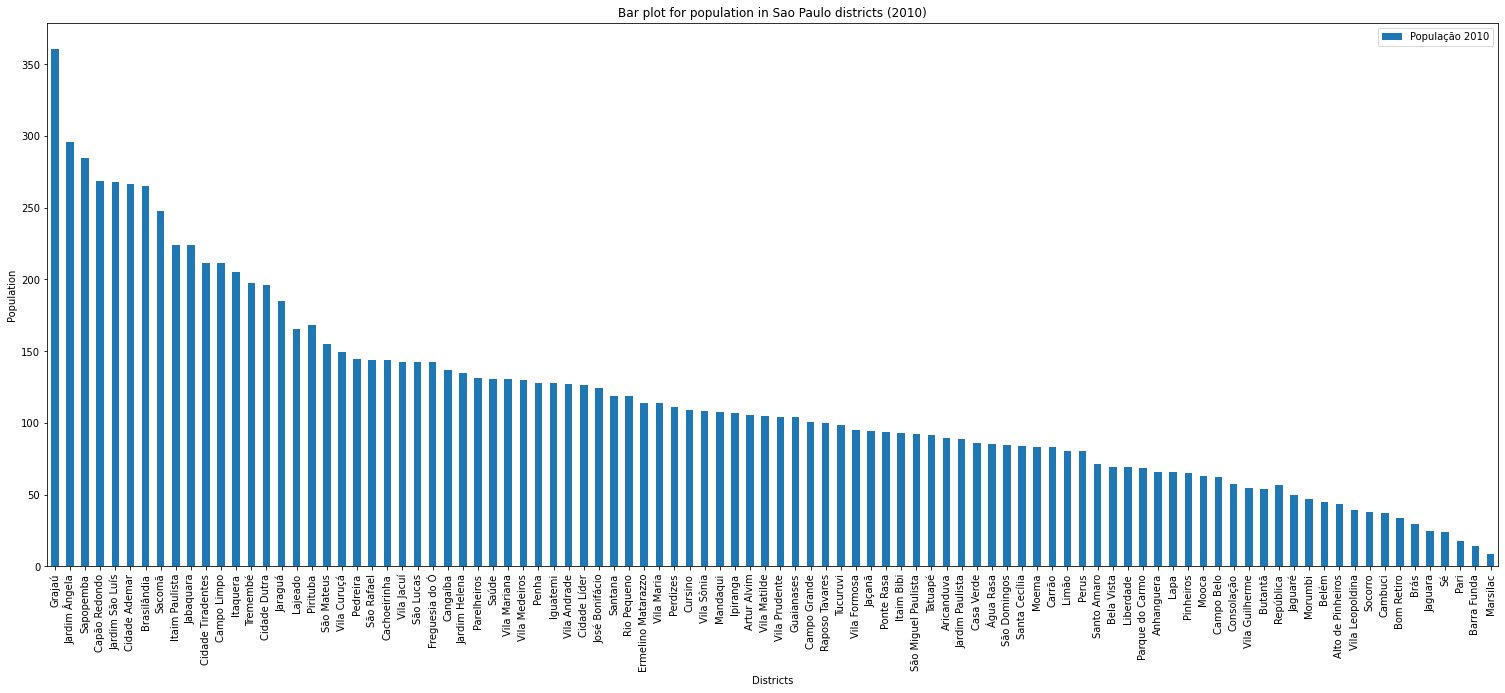

In [10]:
df1.plot(x='Distrito',y='População 2010', kind='bar', figsize=(26, 10))
plt.title('Bar plot for population in Sao Paulo districts (2010)')
plt.ylabel('Population')
plt.xlabel('Districts')
plt.show()

After scrapping district data it is ncessary to aggregate geographical coordinates. Tried Google services, but it asks the user a credit card number. Then geocoder class from Geopy client worked just fine to extract latitude and longitude coordinates for each Sao Paulo district. This data is uploaded to Google Drive and a method to call is 'gdown'.

In [11]:
# Used geopy boring loops to attach districts to lat and long data. Uploaded file to google drive. This is how I import it today
import gdown
url = 'https://drive.google.com/uc?id=1qa_jjyP9mwXkxc03A2jqkMnYMq8QlU6E'
output = 'spgeocoders.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1qa_jjyP9mwXkxc03A2jqkMnYMq8QlU6E
To: C:\Users\Danilo\Downloads\Capstone\spgeocoders.csv
100%|██████████| 3.30k/3.30k [00:00<?, ?B/s]


'spgeocoders.csv'

The above dataframe looks like the one below.

In [12]:
df = pd.read_csv('spgeocoders.csv')
df.head()

,District,Latitude,Longitude
0,Água Rasa,-23.565372,-46.573697
1,Alto de Pinheiros,-23.549549,-46.712155
2,Anhanguera,-23.432909,-46.788534
3,Aricanduva,-23.578024,-46.511454
4,Artur Alvim,-23.539221,-46.485265


Entering Foursquare credentials for API requests.

In [13]:
# Foursquare credentials

CLIENT_ID = 'KF1NUMEWXWSWVCALEAO2ZEQACAT5TGWSXQYHZZMURABZKAAM' # your Foursquare ID
CLIENT_SECRET = '2YBQW1Q1UAWRIK3TBVJNCDOGTLOJ4NUU0MUI4DYXNWHQ5RQO' # your Foursquare Secret
ACCESS_TOKEN = 'ZT4HFFZFHB55EQA0J2GP5OA00GKAZRZHFKJOMJHQPCYFPAOX' # your FourSquare Access Token
VERSION = '20180604'

### Defining all the functions used in this project¶

1 - defining a function to collect all venues available in the districts, limiting to a total of 120 in a 600 meter radius

2 - defining function to collect information about selected business. By passing venues ID's it will return likes, tips, ratings, etc for each business assocoiated to this project

3 - defining the 10 most common venue category for each district

In [14]:
#1
def getNearbyVenues(names, latitudes, longitudes, LIMIT=120, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            v['venue']['id'],
            v['venue']['name'],   
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                             'ID', 
                             'Venue', 
                             'Category']
    
    return(nearby_venues)

#2

def get_venue_details(venue_id):
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data = results['response']['venue']
    
    venue_details=[]
    try:
        venue_name = venue_data['name']
        venue_likes = venue_data['likes']['count']
        venue_rating = venue_data['rating']
        venue_tips = venue_data['tips']['count']
        venue_details.append([venue_name, venue_likes, venue_rating, venue_tips])
    except KeyError:
        pass
        
    column_names = ['Venue', 'Likes', 'Rating', 'Tips']
    info_df = pd.DataFrame(venue_details, columns=column_names)
    return info_df

#3

def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [15]:
sao_paulo_venues = getNearbyVenues(names=df['District'], latitudes=df['Latitude'], longitudes=df['Longitude'])

Água Rasa
Alto de Pinheiros
Anhanguera
Aricanduva
Artur Alvim
Barra Funda
Bela Vista
Belém
Bom Retiro
Brás
Brasilândia
Butantã
Cachoeirinha
Cambuci
Campo Belo
Campo Grande
Campo Limpo
Cangaíba
Capão Redondo
Carrão 
Casa Verde
Cidade Ademar
Cidade Dutra
Cidade Líder
Cidade Tiradentes
Consolação
Cursino
Ermelino Matarazzo
Freguesia do Ó
Grajaú
Guaianazes
Iguatemi
Ipiranga
Itaim Bibi
Itaim Paulista
Itaquera
Jabaquara
Jaçanã
Jaguará
Jaguaré
Jaraguá
Jardim Ângela
Jardim Helena
Jardim Paulista
Jardim São Luís
José Bonifácio
Lapa
Lajeado
Liberdade
Limão
Mandaqui
Marsilac
Moema
Mooca
Morumbi
Parelheiros
Pari
Parque do Carmo
Penha
Pedreira
Perdizes
Perus
Pinheiros
Pirituba
Ponte Rasa
Raposo Tavares
República
Rio Pequeno
Sacomã
Santa Cecília
Santana
Santo Amaro
São Domingos
São Lucas
São Mateus
São Miguel
São Rafael
Sapopemba
Saúde
Sé
Socorro
Tatuapé
Tremembé
Tucuruvi
Vila Andrade
Vila Curuçá
Vila Formosa
Vila Guilherme
Vila Jacuí
Vila Leopoldina
Vila Maria
Vila Mariana
Vila Matilde
Vila Medeiro

Let us take a look at our dataframe.

In [16]:
print(sao_paulo_venues.shape)
sao_paulo_venues.head()
sao_paulo_venues.to_csv(r'C:\Users\Danilo\Downloads\Capstone\export_dataframe.csv', index = False, header=True)

(3341, 4)


A total 3317 venues collected.
By downloading the spreadsheet, it is psossible to find 'pet stores'. A common term used for such business in Brazil is'pet shop', but Fousquare collect it in a different designation.

Identifying 'Pet Store' in Sao Paulo: 

In [17]:
pet = sao_paulo_venues[sao_paulo_venues['Category'] == 'Pet Store']
pet.head()

,District,ID,Venue,Category
57,Anhanguera,5308937d498e95ade0237fb2,Au Miau e Cia Pet Shop,Pet Store
88,Artur Alvim,4e275f91e4cd6c6cb33c58fc,Petcom,Pet Store
177,Bela Vista,4d18d248cc216ea82fd078d3,Mac Dog,Pet Store
499,Campo Belo,4c9edf387ada199c4f479cbc,Dognostic,Pet Store
535,Campo Belo,52a60b7f11d282bb061d38ce,Pet Shop O Mundo de Bono,Pet Store


In [18]:
print('There are {} Pet Stores in Sao Paulo.'.format(pet.shape[0]))

There are 47 Pet Stores in Sao Paulo.


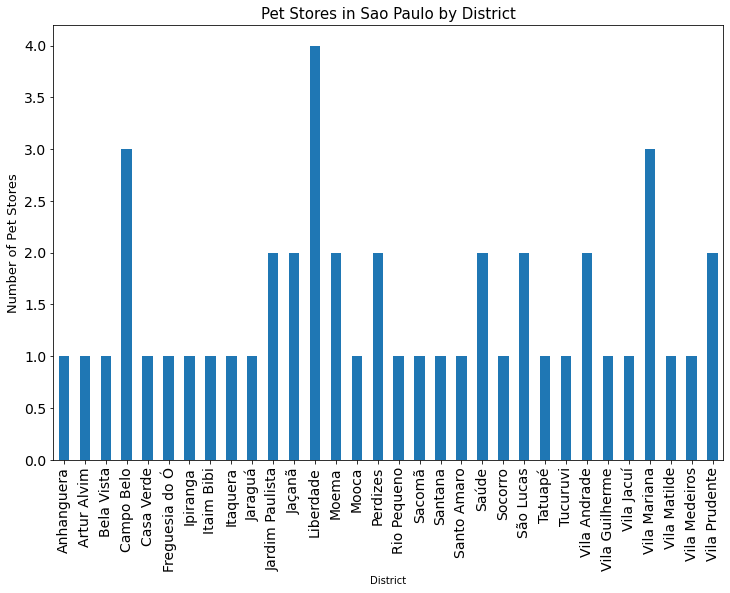

In [19]:
plt.figure(figsize=(12, 8))
pet.groupby('District')['Venue'].count().plot(kind='bar', fontsize=14)
plt.title('Pet Stores in Sao Paulo by District', fontsize=15)
plt.ylabel('Number of Pet Stores', fontsize=13)
plt.show()

There are 47 pet stores in Sao Paulo city.

CampoBelo, Liberdade and Vila Mariana districts present higher number of pet stores.

Use for loop to collect likes, rating and tips info in each district

In [20]:
column_names = ['District', 'Venue', 'Likes', 'Rating', 'Tips']
pet_stats = pd.DataFrame(columns=column_names)
count = 1

for row in pet.values.tolist():
    District, ID, Venue, Category = row
    try:
        venue_details = get_venue_details(ID)
        print(venue_details)
        venue, likes, rating, tips = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id = ', ID)
        
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        venue, likes, rating, tips = [0] * 4
    print('(', count, '/', len(pet),')', 'processed')
    pet_stats = pet_stats.append({'District': District, 
                                'Venue' : venue,
                                'Likes' : likes,
                                'Rating' : rating,
                                'Tips' : tips}, ignore_index=True)
    count += 1

Empty DataFrame
Columns: [Venue, Likes, Rating, Tips]
Index: []
No data available for id =  5308937d498e95ade0237fb2
( 1 / 47 ) processed
    Venue  Likes  Rating  Tips
0  Petcom     20     6.4     9
( 2 / 47 ) processed
     Venue  Likes  Rating  Tips
0  Mac Dog     24     8.7     8
( 3 / 47 ) processed
       Venue  Likes  Rating  Tips
0  Dognostic     37     8.4     9
( 4 / 47 ) processed
                      Venue  Likes  Rating  Tips
0  Pet Shop O Mundo de Bono      9     7.8     2
( 5 / 47 ) processed
     Venue  Likes  Rating  Tips
0  Petland     12     7.3     6
( 6 / 47 ) processed
                     Venue  Likes  Rating  Tips
0  Planeta Dog Rações Ltda     15     6.8     2
( 7 / 47 ) processed
      Venue  Likes  Rating  Tips
0  Pet Zoom      8     7.1     4
( 8 / 47 ) processed
                           Venue  Likes  Rating  Tips
0  Centro Veterinário Bom Pastor     12     8.1     8
( 9 / 47 ) processed
  Venue  Likes  Rating  Tips
0  Petz    128     9.1     5
( 10 / 47 

Let us take a look at the stats dataframe

In [21]:
pet_stats.head()

,District,Venue,Likes,Rating,Tips
0,Anhanguera,0,0,0,0
1,Artur Alvim,Petcom,20,6.4,9
2,Bela Vista,Mac Dog,24,8.7,8
3,Campo Belo,Dognostic,37,8.4,9
4,Campo Belo,Pet Shop O Mundo de Bono,9,7.8,2


Analyzing the dataframe to check each type of each column. For example, is District a object?

In [22]:
pet_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   District  47 non-null     object
 1   Venue     47 non-null     object
 2   Likes     47 non-null     object
 3   Rating    47 non-null     object
 4   Tips      47 non-null     object
dtypes: object(5)
memory usage: 2.0+ KB


District and  venue are okay.
Likes, rating and tips need to be converted to float64.

In [23]:
pet_stats['Likes']=pet_stats['Likes'].astype('float64')
pet_stats['Rating']=pet_stats['Rating'].astype('float64')
pet_stats['Tips']=pet_stats['Tips'].astype('float64')
pet_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   District  47 non-null     object 
 1   Venue     47 non-null     object 
 2   Likes     47 non-null     float64
 3   Rating    47 non-null     float64
 4   Tips      47 non-null     float64
dtypes: float64(3), object(2)
memory usage: 2.0+ KB


### Data types look correct, let's continue our analysis

In [24]:
pet_stats.describe()

,Likes,Rating,Tips
count,47.000000,47.000000,47.000000
mean,34.297872,6.657447,6.000000
std,103.185337,2.651312,11.088576
min,0.000000,0.000000,0.000000
25%,7.000000,6.850000,2.000000
50%,11.000000,7.500000,3.000000
75%,20.000000,8.000000,6.000000
max,651.000000,9.100000,62.000000


In [25]:
# venue with most likes
pet_stats.iloc[pet_stats['Likes'].idxmax()]

District    Jardim Paulista
Venue                Cobasi
Likes                   651
Rating                    9
Tips                     62
Name: 14, dtype: object

In [26]:
# venue with best rating
pet_stats.iloc[pet_stats['Rating'].idxmax()]

District    Itaim Bibi
Venue             Petz
Likes              128
Rating             9.1
Tips                 5
Name: 9, dtype: object

In [27]:
# venue with most tips
pet_stats.iloc[pet_stats['Tips'].idxmax()]

District    Jardim Paulista
Venue                Cobasi
Likes                   651
Rating                    9
Tips                     62
Name: 14, dtype: object

Cobasi in Jardim Paulista district has the most likes and tips count. Petz in Itaim Bibi district is the highest rated.

In table bwlow is listed pet stores in each district in terms of average rating (descending order).

In [28]:
pet_districts = pet_stats.groupby('District', as_index=False).mean()[['District', 'Rating']]
pet_districts.columns = ['District', 'Average Rating']
pet_districts.sort_values(['Average Rating'], ascending=False).head(10)

,District,Average Rating
7,Itaim Bibi,9.100000
19,Santo Amaro,8.800000
2,Bela Vista,8.700000
12,Liberdade,8.325000
10,Jardim Paulista,8.300000
24,Tucuruvi,8.200000
6,Ipiranga,8.100000
3,Campo Belo,7.833333
13,Moema,7.650000
29,Vila Matilde,7.600000


### Visualizing the results

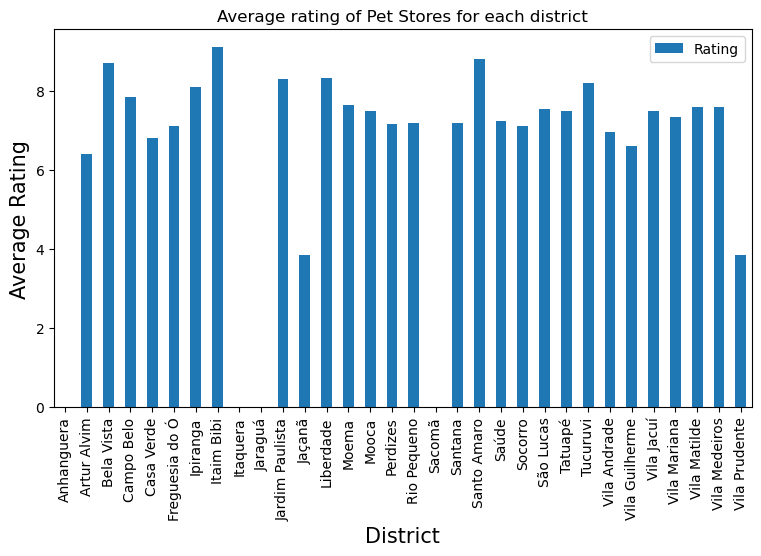

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Pet Stores for each district')
plt.xlabel('District', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
pet_stats.groupby('District', as_index=True).mean()['Rating'].plot(kind='bar')
plt.legend()
plt.show()

Foursquare API returned no pet stores in a few districts.

We will consider all the neighborhoods with average rating greater or equal 7.0 to visualize on a map thus eliminating those with no stores.

In [30]:
pet_districts=pet_districts[pet_districts['Average Rating']>=7.0]
pet_districts

,District,Average Rating
2,Bela Vista,8.700000
3,Campo Belo,7.833333
5,Freguesia do Ó,7.100000
6,Ipiranga,8.100000
7,Itaim Bibi,9.100000
10,Jardim Paulista,8.300000
12,Liberdade,8.325000
13,Moema,7.650000
14,Mooca,7.500000
15,Perdizes,7.150000


Plotting graph for top rating (>7.0) districts.
This is the data set used in the next steps.

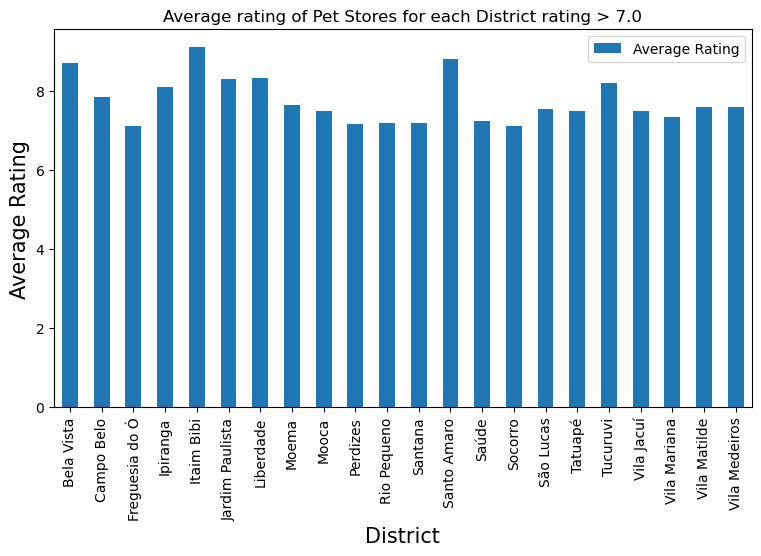

In [31]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Pet Stores for each District rating > 7.0')
plt.xlabel('District', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
pet_districts.groupby('District', as_index=True).mean()['Average Rating'].plot(kind='bar')
plt.legend()
plt.show()

## Feature Selection

Now that we have the average ratings for every district, we will merge this column with our first dataframe, that contains the geographical coordinates for the districts. We will call this new dataframe `pet_merged`.  The latter 3 columns will be used as features for clustering.

In [32]:
pet_merged = pd.merge(pet_districts, df, on='District')
pet_merged = pet_merged[['District', 'Latitude', 'Longitude', 'Average Rating']]
pet_merged

,District,Latitude,Longitude,Average Rating
0,Bela Vista,-23.562210,-46.647766,8.700000
1,Campo Belo,-23.626731,-46.669421,7.833333
2,Freguesia do Ó,-23.487464,-46.695132,7.100000
3,Ipiranga,-23.589273,-46.606162,8.100000
4,Itaim Bibi,-23.584381,-46.678444,9.100000
5,Jardim Paulista,-23.567436,-46.663692,8.300000
6,Liberdade,-23.566704,-46.631809,8.325000
7,Moema,-23.597085,-46.662888,7.650000
8,Mooca,-23.560681,-46.597192,7.500000
9,Perdizes,-23.537929,-46.680671,7.150000


In [33]:
pet_merged.shape

(22, 4)

Everything looks great to go

## One Hot Encoding

One hot enconding is used to find the 10 most common categories of venues present in each district

In [34]:
petsp_districts = pet_merged['District'].unique()
petsp_districts

array(['Bela Vista', 'Campo Belo', 'Freguesia do Ó', 'Ipiranga',
       'Itaim Bibi', 'Jardim Paulista', 'Liberdade', 'Moema', 'Mooca',
       'Perdizes', 'Rio Pequeno', 'Santana', 'Santo Amaro', 'Saúde',
       'Socorro', 'São Lucas', 'Tatuapé', 'Tucuruvi', 'Vila Jacuí',
       'Vila Mariana', 'Vila Matilde', 'Vila Medeiros'], dtype=object)

In [35]:
len(petsp_districts)

22

Starting one hot encoding, first get the dummies from the different venue categories found.

In [36]:
venues_pet = sao_paulo_venues[sao_paulo_venues['District'].isin(petsp_districts)]
pet_onehot = pd.get_dummies(venues_pet['Category'], prefix='', prefix_sep='')
pet_onehot['District'] = venues_pet['District']
fixed_columns = [pet_onehot.columns[-1]] + list(pet_onehot.columns[:-1])
pet_onehot = pet_onehot[fixed_columns]

We will now group by district and calculate the mean of each category then reseting index

In [37]:
pet_grouped = pet_onehot.groupby('District').mean().reset_index()

Then create a dataframe to show the 1st up to the 10th most common venue category for each district:

In [38]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['District'] = pet_grouped['District']

for ind in np.arange(pet_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = most_common_venues(pet_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bela Vista,Pizza Place,Hotel,Bar,Cosmetics Shop,Coffee Shop,Café,Gymnastics Gym,Japanese Restaurant,Chocolate Shop,Italian Restaurant
1,Campo Belo,Bar,Bakery,Restaurant,Brazilian Restaurant,Pet Store,Sushi Restaurant,Middle Eastern Restaurant,Dessert Shop,Pizza Place,Burger Joint
2,Freguesia do Ó,Pizza Place,Gym / Fitness Center,Pharmacy,Department Store,Brazilian Restaurant,Brewery,Chocolate Shop,Sandwich Place,Salon / Barbershop,Cosmetics Shop
3,Ipiranga,Bar,Brazilian Restaurant,Burger Joint,Bakery,Pizza Place,Gym,Coffee Shop,Shoe Store,Restaurant,Cosmetics Shop
4,Itaim Bibi,Italian Restaurant,Japanese Restaurant,Bar,Burger Joint,Ice Cream Shop,Restaurant,Brazilian Restaurant,French Restaurant,Gym / Fitness Center,Hotel


# Methodology for Clustering

Description of all features necessary to run the k-means algorithm

1 - Drop `District` column from the `pet_merged` dataframe (k-means does not handle categorical variables)

2 - Run `StandardScaler` function from `sklearn.preprocessing` to normalize our features

3 - Run `KMeans` algorithm to cluster data. Use elbow method to to select the optimal number of clusters

Defining features

In [39]:
cluster_features = pet_merged.drop('District', axis=1)
cluster_features.head()

,Latitude,Longitude,Average Rating
0,-23.562210,-46.647766,8.700000
1,-23.626731,-46.669421,7.833333
2,-23.487464,-46.695132,7.100000
3,-23.589273,-46.606162,8.100000
4,-23.584381,-46.678444,9.100000


Normalizing features

In [40]:
X = cluster_features.values[:, :]
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset[:5]

array([[-0.0350997 , -0.34489181,  1.64103489],
       [-1.4161095 , -0.66203485,  0.13735534],
       [ 1.56476636, -1.03857905, -1.13498889],
       [-0.61435712,  0.26440946,  0.60002597],
       [-0.50964858, -0.794179  ,  2.33504083]])

## Clustering Districts

The Elbow method is a very popular technique and the idea is to run k-means clustering for a range of clusters k (let’s say from 1 to 10) and for each value, we are calculating the sum of squared distances from each point to its assigned center(distortions).

When the distortions are plotted and the plot looks like an arm then the “elbow” (the point of inflection on the curve) is the best value of k.

In [41]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(cluster_dataset)
    distortions.append(kmeanModel.inertia_)

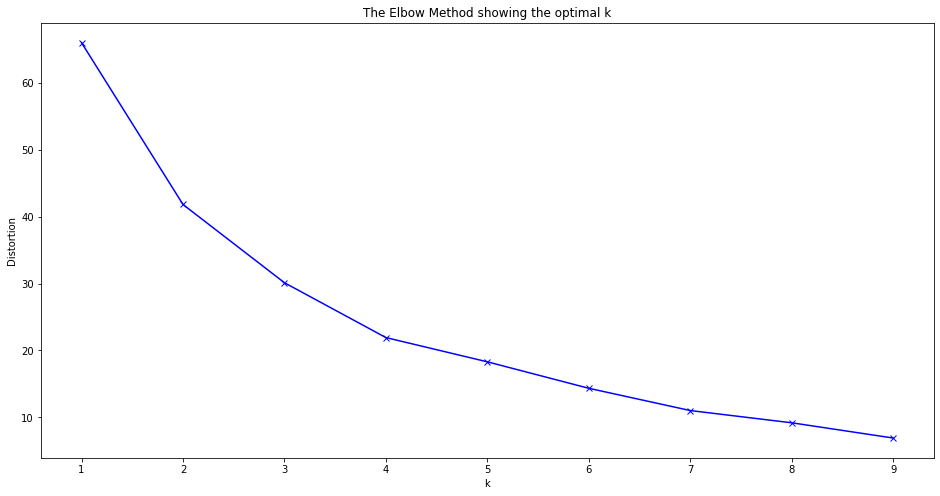

In [42]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

According to the elbow method, it seems that the optimal choice for the number of clusters is k = 4

In [43]:
# elbow k is k=4

k = 4

k_means = KMeans(n_clusters=k, random_state=0)
k_means.fit(cluster_dataset)
k_means.inertia_

21.923524915637156

1 - Storing the estimated labels with the `labels_` attribute and append these labels in a new column in `venues_sorted` dataframe.

2 - Merge it with `pet_merged` dataframe.

In [44]:
labels = k_means.labels_

venues_sorted.insert(loc=0, column='Cluster Label', value=labels)

pet_nearby = pet_merged.join(venues_sorted.set_index('District'), on='District')
pet_nearby.head()

,District,Latitude,Longitude,Average Rating,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bela Vista,-23.562210,-46.647766,8.700000,2,Pizza Place,Hotel,Bar,Cosmetics Shop,Coffee Shop,Café,Gymnastics Gym,Japanese Restaurant,Chocolate Shop,Italian Restaurant
1,Campo Belo,-23.626731,-46.669421,7.833333,1,Bar,Bakery,Restaurant,Brazilian Restaurant,Pet Store,Sushi Restaurant,Middle Eastern Restaurant,Dessert Shop,Pizza Place,Burger Joint
2,Freguesia do Ó,-23.487464,-46.695132,7.100000,3,Pizza Place,Gym / Fitness Center,Pharmacy,Department Store,Brazilian Restaurant,Brewery,Chocolate Shop,Sandwich Place,Salon / Barbershop,Cosmetics Shop
3,Ipiranga,-23.589273,-46.606162,8.100000,1,Bar,Brazilian Restaurant,Burger Joint,Bakery,Pizza Place,Gym,Coffee Shop,Shoe Store,Restaurant,Cosmetics Shop
4,Itaim Bibi,-23.584381,-46.678444,9.100000,2,Italian Restaurant,Japanese Restaurant,Bar,Burger Joint,Ice Cream Shop,Restaurant,Brazilian Restaurant,French Restaurant,Gym / Fitness Center,Hotel


In [45]:
pet_nearby.shape

(22, 15)

Each district have their geographical coordinates, pet store average rating, cluster label and the 10 most common venue categories.

Display Sao Paulo map and clustering it as defined above: 

In [46]:
address = 'São Paulo, SP'

geolocator = Nominatim(user_agent='sp_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of São Paulo are {}, {}.'.format(latitude, longitude))

The geographical coordinates of São Paulo are -23.5506507, -46.6333824.


In [47]:
k = 4 # optimal number of clusters

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for clusters
x = np.arange(k)
ys = [i + x + (i * x) ** 2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, dist, cluster in zip(pet_nearby['Latitude'], 
                                   pet_nearby['Longitude'], 
                                   pet_nearby['District'], 
                                   pet_nearby['Cluster Label']):
    label = folium.Popup(str(dist) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng], 
        radius=5, 
        popup=label, 
        color=rainbow[cluster-1], 
        fill=True, 
        fill_color=rainbow[cluster-1], 
        fill_opacity=.7).add_to(map_clusters)
    
map_clusters

In [48]:
map_clusters.save('sp_dists_clustered.html')

# Results

Finally, we will take a closer look at each cluster to find out the kinds of venues we can find in each of the districts assigned to them.

In [49]:
cluster_0 = pet_nearby.loc[pet_nearby['Cluster Label'] == 0, 
                              pet_nearby.columns[[0] + [3] + list(range(5, pet_nearby.shape[1]))]]
cluster_0

,District,Average Rating,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Tatuapé,7.5,Coffee Shop,Pizza Place,Dessert Shop,Ice Cream Shop,Burger Joint,Restaurant,Café,Cosmetics Shop,Grocery Store,Bar
17,Tucuruvi,8.2,Pizza Place,Fast Food Restaurant,Ice Cream Shop,Bar,Dessert Shop,Chocolate Shop,Clothing Store,Bakery,Market,Snack Place
18,Vila Jacuí,7.5,Bar,Bakery,Burger Joint,Gym / Fitness Center,Clothing Store,College Quad,Hardware Store,Pastelaria,BBQ Joint,Fast Food Restaurant
20,Vila Matilde,7.6,Pizza Place,Bar,Ice Cream Shop,Gym / Fitness Center,Restaurant,Brazilian Restaurant,Burger Joint,Supermarket,Farmers Market,Paper / Office Supplies Store
21,Vila Medeiros,7.6,Brazilian Restaurant,Pizza Place,Event Space,Northeastern Brazilian Restaurant,Pastelaria,Farmers Market,Bakery,Market,Convenience Store,Lottery Retailer


In [50]:
cluster_0['Average Rating'].mean()

7.68

In [51]:
cluster_1 = pet_nearby.loc[pet_nearby['Cluster Label'] == 1, 
                              pet_nearby.columns[[0] + [3] + list(range(5, pet_nearby.shape[1]))]]
cluster_1

,District,Average Rating,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Campo Belo,7.833333,Bar,Bakery,Restaurant,Brazilian Restaurant,Pet Store,Sushi Restaurant,Middle Eastern Restaurant,Dessert Shop,Pizza Place,Burger Joint
3,Ipiranga,8.100000,Bar,Brazilian Restaurant,Burger Joint,Bakery,Pizza Place,Gym,Coffee Shop,Shoe Store,Restaurant,Cosmetics Shop
7,Moema,7.650000,Dessert Shop,Supermarket,Burger Joint,Plaza,Pizza Place,Pharmacy,Italian Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Massage Studio
8,Mooca,7.500000,Bar,Burger Joint,Bakery,Gym,Gym / Fitness Center,Dessert Shop,Pizza Place,Brazilian Restaurant,Restaurant,Mexican Restaurant
13,Saúde,7.250000,Pharmacy,Pizza Place,Bakery,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Martial Arts School,Juice Bar,Chocolate Shop,Pet Store,Japanese Restaurant
14,Socorro,7.100000,Bakery,Farmers Market,Pizza Place,Candy Store,Pet Store,Market,Food Truck,Soccer Field,Ice Cream Shop,Fruit & Vegetable Store
15,São Lucas,7.550000,Dessert Shop,Bakery,Pet Store,Food Truck,Pizza Place,Gym / Fitness Center,Bar,Chinese Restaurant,Chocolate Shop,Furniture / Home Store
19,Vila Mariana,7.333333,Restaurant,Pizza Place,Ice Cream Shop,Pet Store,General Entertainment,Spa,Pharmacy,Farmers Market,Burger Joint,Hostel


In [52]:
cluster_1['Average Rating'].mean()

7.539583333333334

In [53]:
cluster_2 = pet_nearby.loc[pet_nearby['Cluster Label'] == 2, 
                              pet_nearby.columns[[0] + [3] + list(range(5, pet_nearby.shape[1]))]]
cluster_2

,District,Average Rating,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bela Vista,8.700,Pizza Place,Hotel,Bar,Cosmetics Shop,Coffee Shop,Café,Gymnastics Gym,Japanese Restaurant,Chocolate Shop,Italian Restaurant
4,Itaim Bibi,9.100,Italian Restaurant,Japanese Restaurant,Bar,Burger Joint,Ice Cream Shop,Restaurant,Brazilian Restaurant,French Restaurant,Gym / Fitness Center,Hotel
5,Jardim Paulista,8.300,Italian Restaurant,Hotel,Gym / Fitness Center,Brazilian Restaurant,Restaurant,Middle Eastern Restaurant,Spanish Restaurant,Japanese Restaurant,Dessert Shop,Burger Joint
6,Liberdade,8.325,Pizza Place,Gym / Fitness Center,Bakery,Brazilian Restaurant,Farmers Market,Pet Store,Pharmacy,Korean Restaurant,Supermarket,BBQ Joint
12,Santo Amaro,8.800,Gym,Restaurant,Bar,Tea Room,Brazilian Restaurant,Japanese Restaurant,Burger Joint,Sandwich Place,Bike Rental / Bike Share,Metro Station


In [54]:
cluster_2['Average Rating'].mean()

8.645

In [55]:
cluster_3 = pet_nearby.loc[pet_nearby['Cluster Label'] == 3, 
                              pet_nearby.columns[[0] + [3] + list(range(5, pet_nearby.shape[1]))]]
cluster_3

,District,Average Rating,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Freguesia do Ó,7.10,Pizza Place,Gym / Fitness Center,Pharmacy,Department Store,Brazilian Restaurant,Brewery,Chocolate Shop,Sandwich Place,Salon / Barbershop,Cosmetics Shop
9,Perdizes,7.15,Burger Joint,Bar,Gym / Fitness Center,Pharmacy,Dessert Shop,Italian Restaurant,Pizza Place,Restaurant,Café,Bakery
10,Rio Pequeno,7.20,Fruit & Vegetable Store,Convenience Store,Gym,Bar,Chocolate Shop,Bakery,Food & Drink Shop,BBQ Joint,Health & Beauty Service,Food Truck
11,Santana,7.20,Burger Joint,Pharmacy,Pizza Place,Middle Eastern Restaurant,Japanese Restaurant,Cosmetics Shop,Gym / Fitness Center,Food Truck,Restaurant,Brewery


In [56]:
cluster_3['Average Rating'].mean()

7.1625